In [37]:
import pandas as pd
from prophet import Prophet
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import signal
import matplotlib.pyplot as plt
from statsmodels.tools.eval_measures import rmse

In [2]:
df = pd.read_csv("../data/MLTollsStackOverflow.csv")
len(df)

132

In [3]:
df.head()

,month,nltk,spacy,stanford-nlp,python,r,numpy,scipy,matlab,machine-learning,...,Plato,Sympy,Flair,stanford-nlp.1,pyqt,Nolearn,Lasagne,OCR,Apache-spark-mlib,azure-virtual-machine
0,09-Jan,0,0,0,631,8,6,2,19,8,...,0,1,0,0,5,0,0,5,0,0
1,09-Feb,1,0,0,633,9,7,3,27,4,...,0,0,0,0,5,0,0,11,0,0
2,09-Mar,0,0,0,766,4,4,2,24,3,...,0,0,0,0,7,0,0,2,0,0
3,09-Apr,0,0,0,768,12,6,3,32,10,...,0,0,0,0,11,0,0,5,0,0
4,09-May,1,0,0,1003,2,7,2,42,7,...,0,0,0,0,10,0,0,3,0,0


In [5]:
print(df['month'][0])
print(df['month'].iloc[-1])

09-Jan
19-Dec


We have a dataset containing monthly question counts for specific topics. The counts start in January 2009 and end in December 2019 totalling in 11 years of data.

### Data Preparation

In [7]:
df['month'] = pd.to_datetime(df['month'], format="%y-%b")
# each column contains the number of questions for a given topic
# we are interested in the total questions asked and need to sum those columns
cols_to_sum = [col for col in df.columns if col != 'month']
df['Total_Questions'] = df[cols_to_sum].sum(axis=1).astype(int)
time_series_df = df.copy()
time_series_df = time_series_df[['month', 'Total_Questions']]
time_series_df.head()

,month,Total_Questions
0,2009-01-01,1664
1,2009-02-01,1786
2,2009-03-01,2002
3,2009-04-01,2106
4,2009-05-01,2646


In [12]:
len_total_dataset = len(time_series_df)
len_test_dataset = 12 # we want to evaluate the predictions on one year of data
len_train_dataset = len_total_dataset - len_test_dataset

In [13]:
train = time_series_df.iloc[:len_train_dataset]
test = time_series_df.iloc[len_train_dataset:]

### Seasonal Decomposition

In [14]:
from scipy.stats import kruskal
import numpy as np
# Check if there is seasonality in our series
# check the below link for documentation of this function
# https://knk00.medium.com/how-to-determine-seasonality-without-plots-f18cee913b95
def seasonality_test(series):
        seasoanl = False
        idx = np.arange(len(series.index)) % 12
        H_statistic, p_value = kruskal(series, idx)
        if p_value <= 0.05:
            seasonal = True
        return seasonal
seasonality_test(train['Total_Questions'])

True

We can reject the null hypothesis which states the series is non-seasonal.

<AxesSubplot: xlabel='month'>

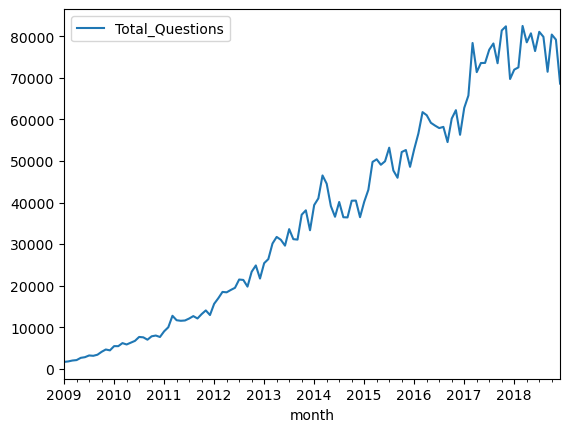

In [18]:
decompose_df = train.set_index('month')
decompose_df.plot()

The above chart shows a rather multiplicative seasonality, meaning we will need to set a specificparameter in the Facebook Prophet function. This also shows in the below chart which contains a detrended time series with increasing amplification with ongoing time.

<AxesSubplot: >

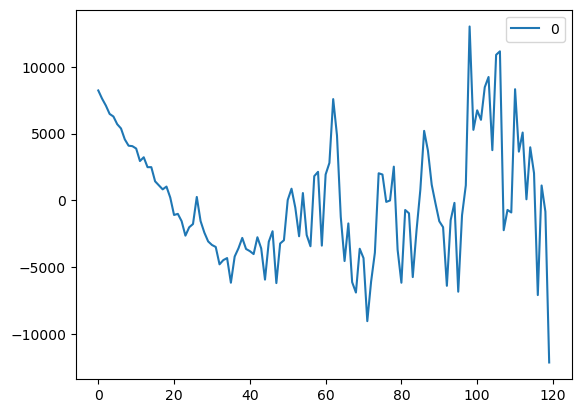

In [21]:
detrended = signal.detrend(decompose_df['Total_Questions'])
detrended_df = pd.DataFrame(detrended)
detrended_df.plot()

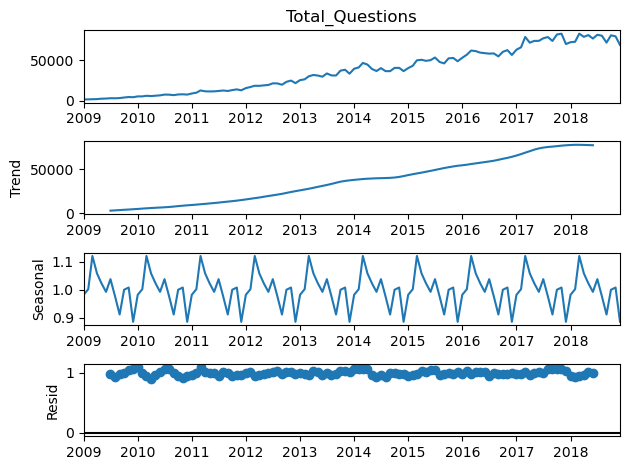

In [22]:
result = seasonal_decompose(decompose_df['Total_Questions'], model='mult')  # model='mul' also works
result.plot();

## Facebook Prophet

Prophet requires columns to be named in the below way to function

In [26]:
train.columns = ['ds','y']
test.columns = ['ds','y']

20:58:55 - cmdstanpy - INFO - Chain [1] start processing
20:58:56 - cmdstanpy - INFO - Chain [1] done processing


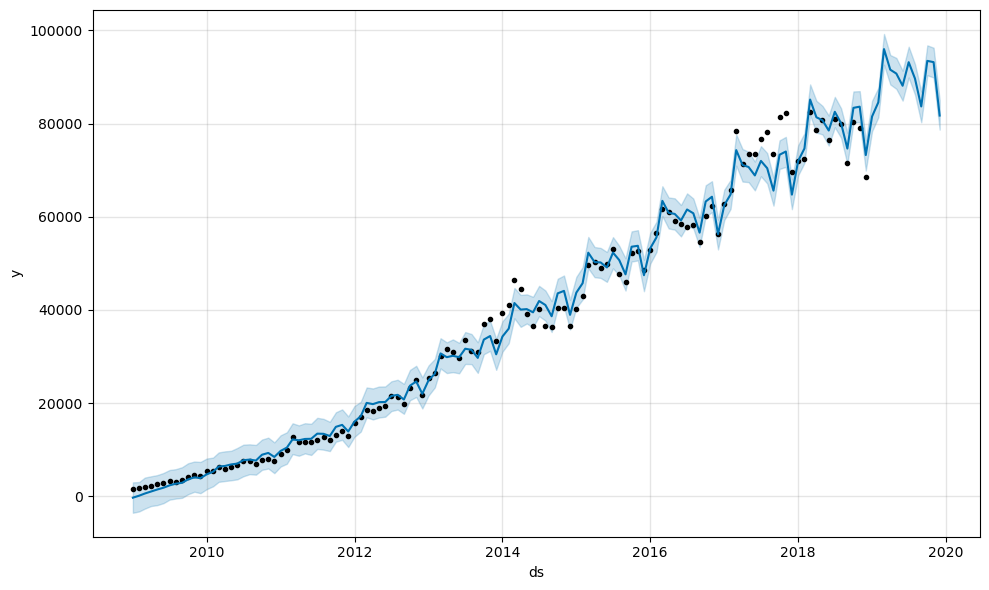

In [27]:
m = Prophet(seasonality_mode='multiplicative')
m.fit(train)
future = m.make_future_dataframe(12, freq='MS')
forecast = m.predict(future)
fig = m.plot(forecast)

In [28]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
127,2019-08-01,90345.688483,86232.725447,92786.768940,90212.274001,90477.293909,-0.007407,-0.007407,-0.007407,-0.007407,-0.007407,-0.007407,0.0,0.0,0.0,89676.455979
128,2019-09-01,91178.779142,80288.581641,86883.688409,91011.557962,91343.647042,-0.082255,-0.082255,-0.082255,-0.082255,-0.082255,-0.082255,0.0,0.0,0.0,83678.840643
129,2019-10-01,91984.995908,90380.381092,96802.935609,91785.862891,92180.130981,0.016133,0.016133,0.016133,0.016133,0.016133,0.016133,0.0,0.0,0.0,93468.949748
130,2019-11-01,92818.086567,89899.667425,96296.621356,92588.581747,93052.976247,0.004117,0.004117,0.004117,0.004117,0.004117,0.004117,0.0,0.0,0.0,93200.229804
131,2019-12-01,93624.303334,78704.733868,85031.802955,93357.177165,93894.395650,-0.127025,-0.127025,-0.127025,-0.127025,-0.127025,-0.127025,0.0,0.0,0.0,81731.637147


In [30]:
test.tail()

,ds,y
127,2019-08-01,90688
128,2019-09-01,86196
129,2019-10-01,104122
130,2019-11-01,102938
131,2019-12-01,89308


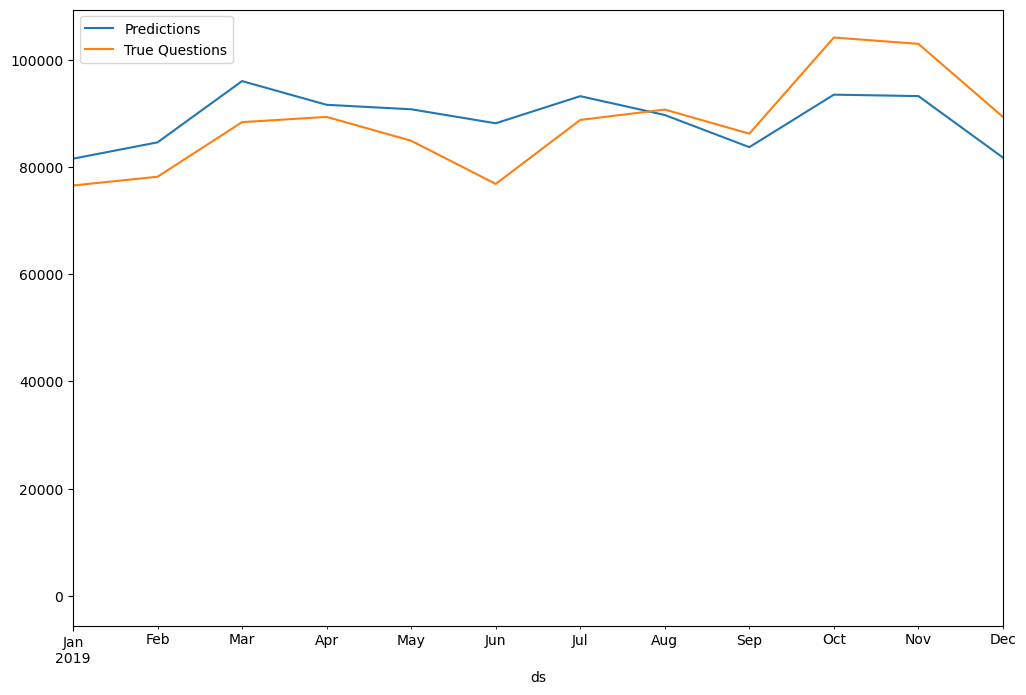

In [36]:
ax = forecast.plot(x='ds',y='yhat',label='Predictions',legend=True,figsize=(12,8))
test.plot(x='ds',y='y',label='True Questions',legend=True,ax=ax,xlim=('2019-01-01','2019-12-01'))
plt.show()

In [38]:
predictions = forecast.iloc[-12:]['yhat']
rmse(predictions,test['y'])

6981.0977576331325

In [39]:
test.mean()

/tmp/ipykernel_2587/1706541227.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  test.mean()


y    88005.166667
dtype: float64

In [42]:
rmse(predictions,test['y'])

6981.0977576331325

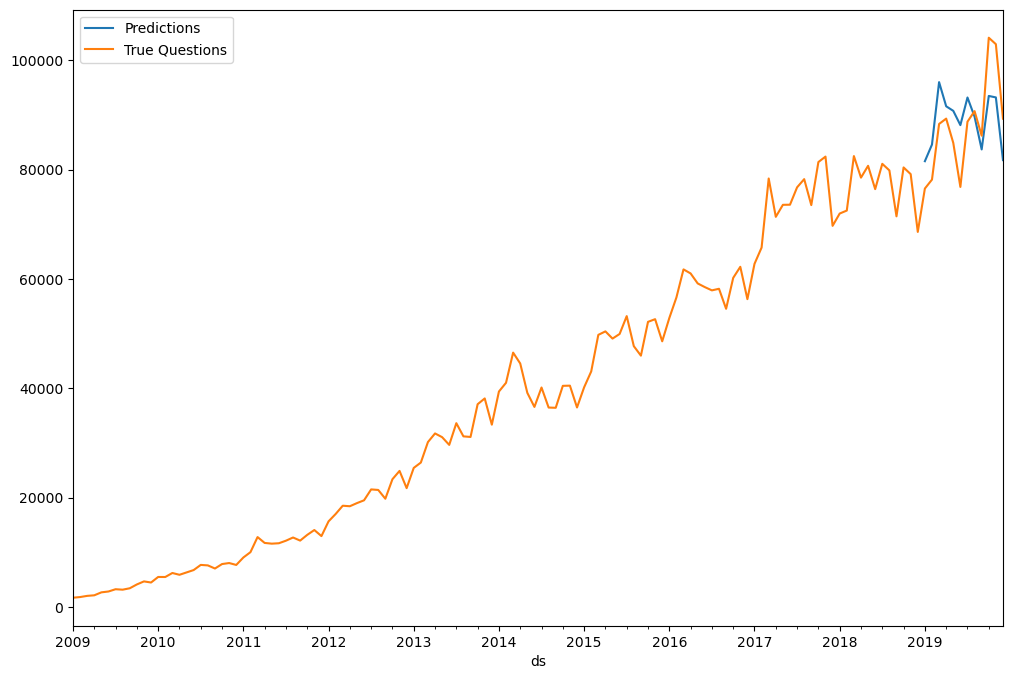

In [51]:
ax = forecast.iloc[-12:].plot(x='ds',y='yhat',label='Predictions',legend=True,figsize=(12,8), xlim=('2019-01-01','2019-12-01'))
time_series_df.plot(x='ds',y='y',label='True Questions',legend=True,ax=ax)
plt.show()

# Prophet Diagnostics

Prophet includes functionality for time series cross validation to measure forecast error using historical data. This is done by selecting cutoff points in the history, and for each of them fitting the model using data only up to that cutoff point. We can then compare the forecasted values to the actual values.

In [52]:
from prophet.diagnostics import cross_validation,performance_metrics
from prophet.plot import plot_cross_validation_metric

In [53]:
len(df)

132

In [54]:
len(df)/12

11.0

The initial period should be long enough to capture all of the components of the model, in particular seasonalities and extra regressors: at least a year for yearly seasonality, at least a week for weekly seasonality, etc.

In [71]:
# Initial 2 years training period
initial = 2 * 365
initial = str(initial) + ' days'
# Fold every 2 years
period = 2 * 365
period = str(period) + ' days'
# Forecast 1 year into the future
horizon = 365
horizon = str(horizon) + ' days'

In [72]:
df_cv = cross_validation(m, initial=initial, period=period, horizon = horizon)

  0%|          | 0/4 [00:00<?, ?it/s]

21:24:04 - cmdstanpy - INFO - Chain [1] start processing
21:24:05 - cmdstanpy - INFO - Chain [1] done processing
21:24:05 - cmdstanpy - INFO - Chain [1] start processing
21:24:05 - cmdstanpy - INFO - Chain [1] done processing
21:24:06 - cmdstanpy - INFO - Chain [1] start processing
21:24:06 - cmdstanpy - INFO - Chain [1] done processing
21:24:06 - cmdstanpy - INFO - Chain [1] start processing
21:24:06 - cmdstanpy - INFO - Chain [1] done processing


In [73]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2012-01-01,12492.996349,12264.449396,12704.796434,15634,2011-12-03
1,2012-02-01,14854.422322,14603.125299,15101.988972,16984,2011-12-03
2,2012-03-01,15112.047033,14880.341076,15336.977025,18496,2011-12-03
3,2012-04-01,14972.698221,14733.858051,15213.791442,18402,2011-12-03
4,2012-05-01,18047.112179,17810.031843,18279.406628,18974,2011-12-03


In [74]:
df_cv.tail()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
43,2018-08-01,86122.038946,83856.708838,88524.273214,79848,2017-12-01
44,2018-09-01,82179.661290,79868.761189,84737.349894,71444,2017-12-01
45,2018-10-01,91917.853394,89453.349478,94341.930198,80390,2017-12-01
46,2018-11-01,92639.202929,90018.934451,95093.272456,79164,2017-12-01
47,2018-12-01,81935.186236,79329.205680,84413.189400,68594,2017-12-01


In [75]:
performance_metrics(df_cv)

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,31 days,1.282954e+07,3581.834895,3191.746131,0.090489,0.065806,0.095808,0.00
1,60 days,1.149684e+07,3390.699117,2938.889638,0.071609,0.065806,0.073416,0.00
2,61 days,1.222426e+07,3496.320690,3080.600381,0.073181,0.067870,0.075064,0.00
3,62 days,2.471031e+07,4970.946106,3926.002456,0.084694,0.090895,0.085486,0.00
4,89 days,2.535190e+07,5035.066931,3995.543242,0.094905,0.078390,0.098031,0.00
5,90 days,3.149702e+07,5612.220247,4164.205902,0.090463,0.077490,0.093323,0.25
6,120 days,3.117291e+07,5583.270882,3888.665913,0.085175,0.075759,0.088120,0.50
7,121 days,3.223204e+07,5677.327160,3628.179347,0.082305,0.070327,0.084870,0.50
8,150 days,3.466236e+07,5887.474511,4106.865635,0.076232,0.082445,0.072726,0.25
9,151 days,1.536230e+07,3919.477269,3234.237387,0.065797,0.062786,0.063862,0.25


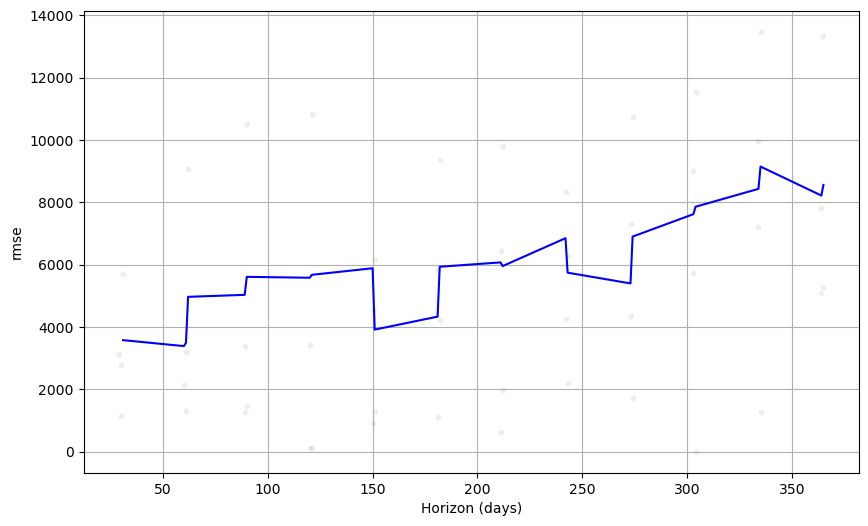

In [76]:
plot_cross_validation_metric(df_cv, metric='rmse')
plt.show()

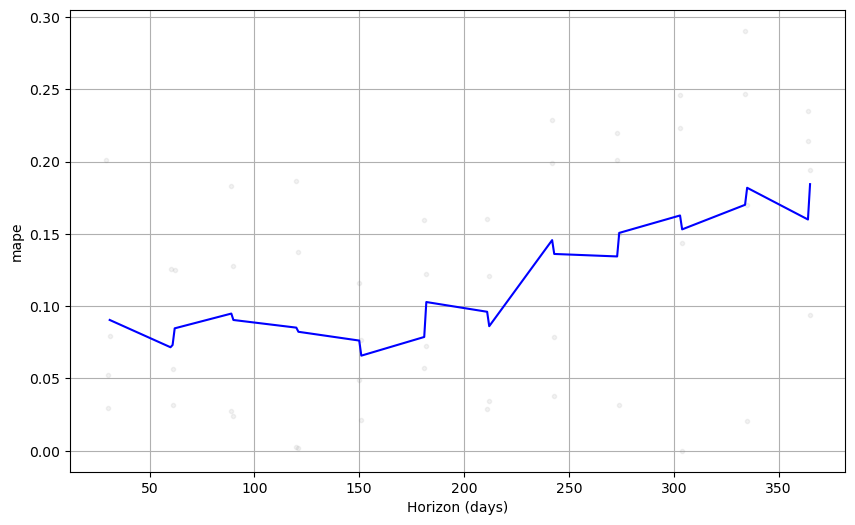

In [77]:
plot_cross_validation_metric(df_cv, metric='mape')
plt.show()

### Hyperparameter Tuning

In [78]:
2 * 365

730

In [ ]:
# Initial 2 years training period
initial = 2 * 365
initial = str(initial) + ' days'
# Fold every 2 years
period = 2 * 365
period = str(period) + ' days'
# Forecast 1 year into the future
horizon = 365
horizon = str(horizon) + ' days'
df_cv = cross_validation(m, initial=initial, period=period, horizon = horizon)

In [80]:
import itertools
import numpy as np
import pandas as pd

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_mode':  ['additive', 'multiplicative'],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(train)  # Fit model with given params
    df_cv = cross_validation(m, initial='730 days', period='730 days', horizon='365 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

21:38:37 - cmdstanpy - INFO - Chain [1] start processing
21:38:37 - cmdstanpy - INFO - Chain [1] done processing
21:38:37 - cmdstanpy - ERROR - Chain [1] error: error during processing Communication error on send
Optimization terminated abnormally. Falling back to Newton.
21:38:37 - cmdstanpy - INFO - Chain [1] start processing
21:38:37 - cmdstanpy - INFO - Chain [1] done processing
21:38:38 - cmdstanpy - INFO - Chain [1] start processing
21:38:38 - cmdstanpy - INFO - Chain [1] start processing
21:38:38 - cmdstanpy - INFO - Chain [1] start processing
21:38:38 - cmdstanpy - INFO - Chain [1] start processing
21:38:38 - cmdstanpy - INFO - Chain [1] done processing
21:38:38 - cmdstanpy - INFO - Chain [1] done processing
21:38:38 - cmdstanpy - INFO - Chain [1] done processing
21:38:38 - cmdstanpy - INFO - Chain [1] done processing
21:38:38 - cmdstanpy - INFO - Chain [1] start processing
21:38:38 - cmdstanpy - INFO - Chain [1] done processing
21:38:38 - cmdstanpy - ERROR - Chain [1] error: e

   changepoint_prior_scale seasonality_mode         rmse
0                    0.001         additive  6957.154000
1                    0.001   multiplicative  7213.988250
2                    0.010         additive  4568.560616
3                    0.010   multiplicative  4876.131881
4                    0.100         additive  6429.339367
5                    0.100   multiplicative  6833.732751
6                    0.500         additive  6754.510901
7                    0.500   multiplicative  7447.738951


In [81]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive'}
